In [1]:
from pyspark import SparkContext, SparkConf
cf = SparkConf()
cf.set("spark.submit.deployMode","client")
sc = SparkContext.getOrCreate(cf)
from pyspark.sql import SparkSession
spark = SparkSession \
	    .builder \
	    .appName("TransitTrends-Taxi-Data-Cleaning") \
	    .config("spark.some.config.option", "some-value") \
	    .getOrCreate()
        #.config("spark.driver.extraJavaOptions", "-Dsun.net.client.defaultConnectTimeout=100000 -Dsun.net.client.defaultReadTimeout=100000") \
        #.config("spark.executor.heartbeatInterval", "100000ms") \
        #.config("spark.network.timeout", "12000s") \


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/05/07 00:57:28 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
23/05/07 00:57:28 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
23/05/07 00:57:28 INFO org.apache.spark.SparkEnv: Registering BlockManagerMasterHeartbeat
23/05/07 00:57:28 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator


In [2]:
#importing libraries
from pyspark.sql.functions import lit
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry import Polygon
from shapely.geometry import MultiPolygon
import math
import time
import pyspark.sql.functions as F
from pyspark.sql.functions import concat
from pyspark.sql.functions import count,asc
import matplotlib.pyplot as plt
from pyspark.sql.functions import desc

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/miniconda3/share/proj failed


In [3]:
# importing green cabs data, dropping unnecessary coloumns and renaming few coloumns to match yellow cabs data:
#green_cabs_df = spark.read.csv(path='/shared/TAXI_SAMPLE/GREEN_CABS/',header=True, inferSchema= True).withColumn("taxi_type", lit("green")).drop("trip_type").withColumnRenamed("lpep_dropoff_datetime", "tpep_dropoff_datetime").withColumnRenamed("lpep_pickup_datetime", "tpep_pickup_datetime")
green_cabs_df = spark.read.option("dictionaryFilterEnabled", "false").parquet("/shared/TAXI/GREEN_CABS/").withColumn("taxi_type", lit("green")).drop("trip_type").withColumnRenamed("lpep_dropoff_datetime", "tpep_dropoff_datetime").withColumnRenamed("lpep_pickup_datetime", "tpep_pickup_datetime")

# importing yellow cabs data:
#yellow_cabs_df = spark.read.csv(path='/shared/TAXI_SAMPLE/YELLOW_CABS/',header=True, inferSchema= True).withColumn("taxi_type", lit("yellow"))
yellow_cabs_df = spark.read.option("dictionaryFilterEnabled", "false").parquet("/shared/TAXI/YELLOW_CABS/").withColumn("taxi_type", lit("yellow"))

# note: sometime there might be .ipynb checkpoints in /shared/GREEN_CABS folder. remove them hdfs before running this cell
yellow_cabs_df.printSchema()

root
 |-- VendorID: long (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: integer (nullable = true)
 |-- taxi_type: string (nullable = false)



In [4]:
green_cabs_df.printSchema()

root
 |-- VendorID: long (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- ehail_fee: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- payment_type: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- taxi_type: string (nullable = false)



In [5]:
print(green_cabs_df.count())

9944318


In [6]:
print(yellow_cabs_df.count())

179807942


In [7]:
# combining yellow and green cabs data into a single dataset:
cabs_df = yellow_cabs_df.union(green_cabs_df)
# dropping unnnecessary coloumns:
cabs_df = cabs_df.drop("store_and_fwd_flag")

In [8]:
print(cabs_df.count())

189752260


In [9]:
# Clean the column names
cabs_df = cabs_df.select([F.col(column).alias(column.strip()) for column in cabs_df.columns])
#Filter for data in 2019-2021, removing the last week of 2018 from the dataset
cabs_df = cabs_df.filter(F.year("tpep_pickup_datetime").isin([2019, 2020, 2021]))

In [10]:
#converting pickup and dropoff datetime to timestamp
cabs_df = cabs_df.withColumn("pickup_date_time", F.to_timestamp(cabs_df["tpep_pickup_datetime"], "MM/dd/yyyyHH:mm:ss"))
cabs_df = cabs_df.withColumn("dropoff_date_time", F.to_timestamp(cabs_df["tpep_dropoff_datetime"], "MM/dd/yyyyHH:mm:ss"))

In [11]:
#dropping unnecesary colomns
cabs_df = cabs_df.drop("tpep_pickup_datetime","tpep_dropoff_datetime")
print(cabs_df.count())

149253995


In [12]:
#cabs_df = cabs_df.withColumn("pickup_datetime", cabs_df["tpep_pickup_datetime"].cast("timestamp"))
cabs_df_1 = cabs_df.withColumn("month", F.month(cabs_df["pickup_date_time"])).withColumn("year", F.year(cabs_df["pickup_date_time"]))

In [13]:
monthly_records = cabs_df_1.select("month","year")
#cabs_df = monthly_records.withColumn("month/year", concat(F.col("month"), F.lit("/"), F.col("year"))).drop("month","year")

In [14]:
monthly_records.show(5)

+-----+----+
|month|year|
+-----+----+
|    3|2019|
|    3|2019|
|    3|2019|
|    3|2019|
|    3|2019|
+-----+----+
only showing top 5 rows



In [15]:

count_df = monthly_records.groupBy('year','month').agg(count('*').alias('count')).orderBy(asc('year'), asc('month'))
count_df.show(5)

+----+-----+-------+
|year|month|  count|
+----+-----+-------+
|2019|    1|8368407|
|2019|    2|7664760|
|2019|    3|8509420|
|2019|    4|8043806|
|2019|    5|8144006|
+----+-----+-------+
only showing top 5 rows



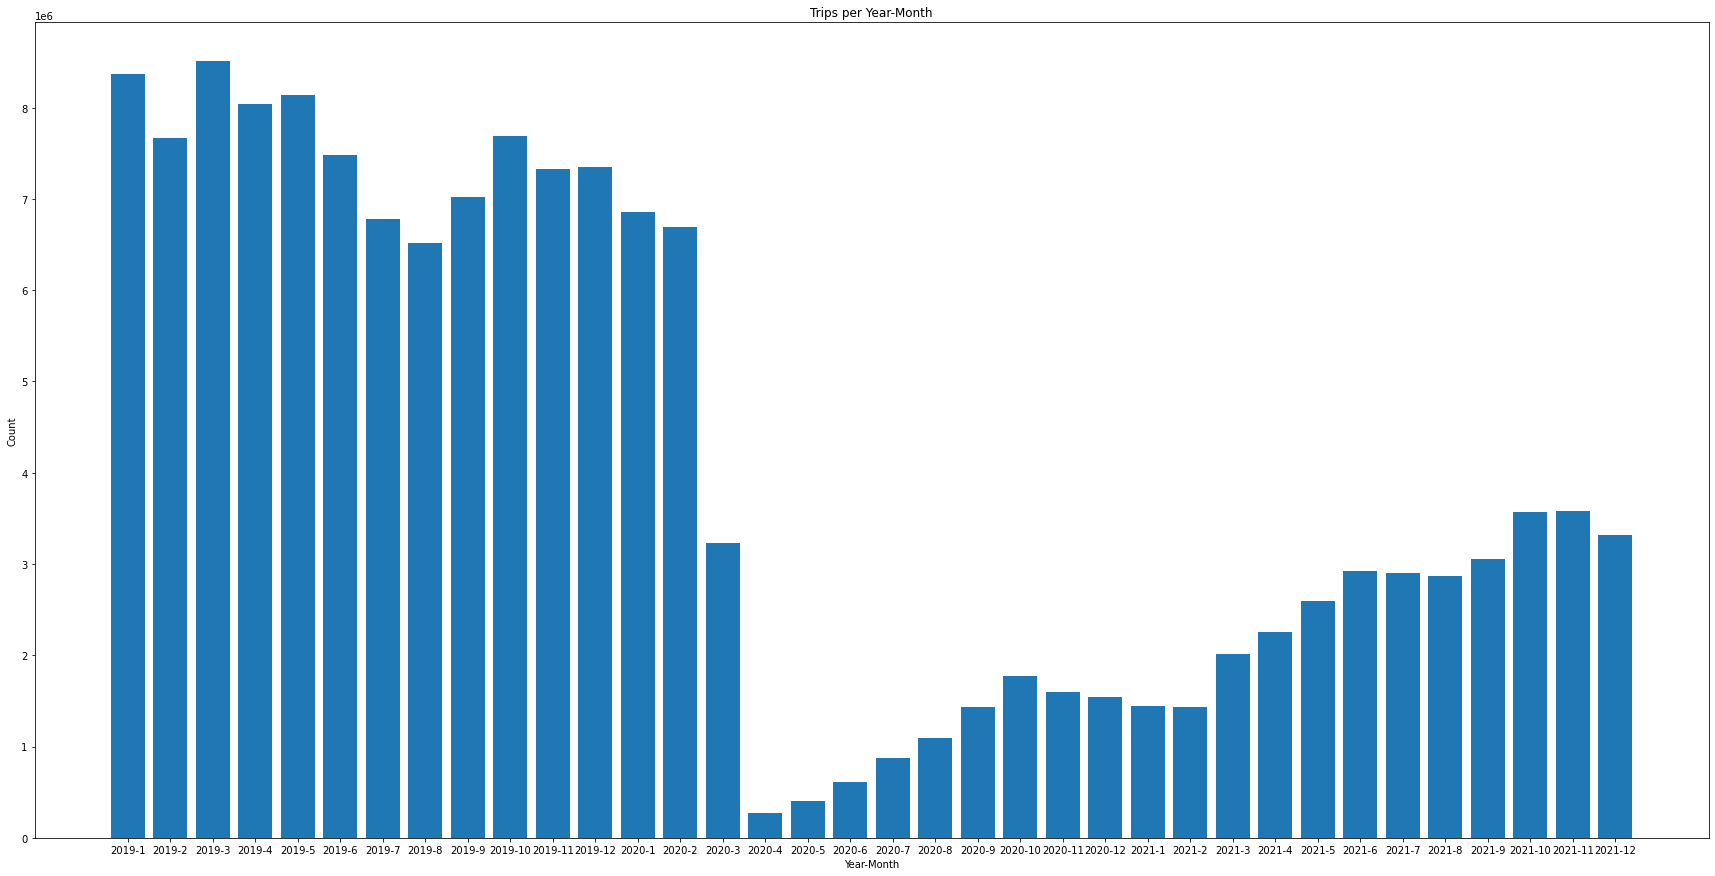

In [16]:


# Convert the PySpark DataFrame to Pandas DataFrame
pd_df = count_df.toPandas()

plt.figure(figsize=(30, 15))

# Create the bar plot using matplotlib
plt.bar(pd_df['year'].astype(str) + '-' + pd_df['month'].astype(str), pd_df['count'])

# Set the title and axis labels
plt.title('Trips per Year-Month')
plt.xlabel('Year-Month')
plt.ylabel('Count')
plt.savefig('trips_per_month.png' , dpi=500)
# Show the plot
plt.show()


In [52]:
#reading taxi zones shape files:
tzdata = gpd.read_file("Taxi_zones.shp")
tzdata.head()

,borough,location_i,objectid,shape_area,shape_leng,zone,geometry
0,EWR,1.0,1.0,0.000782,0.116357,Newark Airport,"POLYGON ((-74.18445 40.69500, -74.18449 40.695..."
1,Queens,2.0,2.0,0.004866,0.433470,Jamaica Bay,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ..."
2,Bronx,3.0,3.0,0.000314,0.084341,Allerton/Pelham Gardens,"POLYGON ((-73.84793 40.87134, -73.84725 40.870..."
3,Manhattan,4.0,4.0,0.000112,0.043567,Alphabet City,"POLYGON ((-73.97177 40.72582, -73.97179 40.725..."
4,Staten Island,5.0,5.0,0.000498,0.092146,Arden Heights,"POLYGON ((-74.17422 40.56257, -74.17349 40.562..."


Text(0.5, 1.0, 'NYC Taxi Zones WGS84 (lat/lon)')

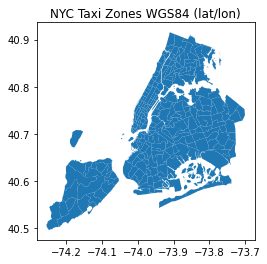

In [53]:
#Plotting all taxi zones
plotnyc = tzdata.plot()
plotnyc.set_title("NYC Taxi Zones WGS84 (lat/lon)")

In [54]:
pu_count_df = cabs_df.groupBy('PULocationID').agg(count('*').alias('count')).orderBy('PULocationID')

pu_count_df.show(5)

+------------+-------+
|PULocationID|  count|
+------------+-------+
|        null|1613788|
|         0.0|  16318|
|         1.0|6471692|
|         2.0| 550090|
|         3.0| 107228|
+------------+-------+
only showing top 5 rows



In [55]:
PU_unique = pu_count_df.select('PULocationID').distinct().orderBy('PULocationID')
print(PU_unique.count())
PU_unique.show(5)

266


+------------+
|PULocationID|
+------------+
|        null|
|         0.0|
|         1.0|
|         2.0|
|         3.0|
+------------+
only showing top 5 rows



In [56]:
unique_loc_id = pd.unique(tzdata['location_i'])
print(len(unique_loc_id))
print(unique_loc_id)

260
[  1.   2.   3.   4.   5.   6.   7.   8.   9.  24.  10.  11.  12.  13.
  18.  25.  14.  15.  22.  23.  16.  17.  19.  20.  21.  26.  27.  28.
  33.  29.  31.  32.  30.  34.  35.  36.  37.  38.  39.  40.  41.  45.
  46.  42.  43.  44.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.
  58.  59.  60.  61.  62.  63.  64.  65.  72.  66.  67.  68.  73.  69.
  70.  71.  79.  80.  74.  85.  86.  75.  76.  77.  78.  81.  87.  82.
  83.  84.  88.  89.  90. 125.  91.  92.  93.  94.  95.  96.  97.  98.
  99. 100. 101. 102. 103. 106. 107. 108. 109. 110. 111. 112. 113. 114.
 115. 116. 117. 118. 119. 120. 149. 150. 121. 122. 123. 124. 126. 127.
 128. 129. 134. 151. 130. 139. 131. 132. 133. 140. 135. 136. 137. 141.
 142. 152. 138. 143. 144. 145. 146. 147. 148. 153. 154. 155. 156. 159.
 157. 158. 160. 161. 162. 163. 164. 170. 165. 166. 167. 178. 168. 169.
 171. 172. 173. 174. 175. 179. 176. 177. 180. 181. 182. 183. 184. 185.
 186. 189. 190. 187. 188. 191. 192. 193. 194. 196. 195. 203. 197. 198.
 1

In [57]:
pu_count_pd = pu_count_df.toPandas()
tzdata = tzdata.merge(pu_count_pd, left_on='location_i', right_on='PULocationID',how='left')
tzdata = tzdata.rename(columns={'count': 'pu_count'}).drop('PULocationID', axis=1)
tzdata['pu_count'] = tzdata['pu_count'].fillna(0)
tzdata.head()

,borough,location_i,objectid,shape_area,shape_leng,zone,geometry,pu_count
0,EWR,1.0,1.0,0.000782,0.116357,Newark Airport,"POLYGON ((-74.18445 40.69500, -74.18449 40.695...",6471692.0
1,Queens,2.0,2.0,0.004866,0.433470,Jamaica Bay,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ...",550090.0
2,Bronx,3.0,3.0,0.000314,0.084341,Allerton/Pelham Gardens,"POLYGON ((-73.84793 40.87134, -73.84725 40.870...",107228.0
3,Manhattan,4.0,4.0,0.000112,0.043567,Alphabet City,"POLYGON ((-73.97177 40.72582, -73.97179 40.725...",254726.0
4,Staten Island,5.0,5.0,0.000498,0.092146,Arden Heights,"POLYGON ((-74.17422 40.56257, -74.17349 40.562...",208352.0


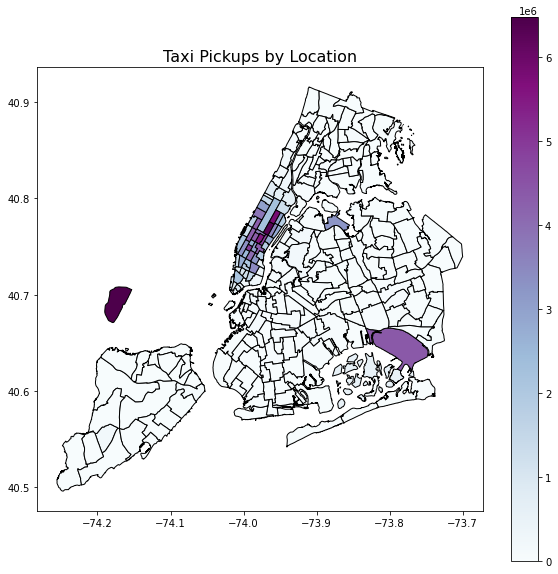

In [59]:
fig, ax = plt.subplots(figsize=(10, 10))
cmap = tzdata.plot(column='pu_count', cmap='BuPu', legend=True, ax=ax, edgecolor='black')
cmap.set_title("Taxi Pickups by Location", fontsize = 16)
plt.show()

In [60]:
do_count_df = cabs_df.groupBy('DOLocationID').agg(count('*').alias('count')).orderBy('DOLocationID')

In [61]:
do_count_pd = do_count_df.toPandas()
tzdata = tzdata.merge(do_count_pd, left_on='location_i', right_on='DOLocationID',how='left')
tzdata = tzdata.rename(columns={'count': 'do_count'}).drop('DOLocationID', axis=1)
tzdata['do_count'] = tzdata['do_count'].fillna(0)
tzdata.head()

,borough,location_i,objectid,shape_area,shape_leng,zone,geometry,pu_count,do_count
0,EWR,1.0,1.0,0.000782,0.116357,Newark Airport,"POLYGON ((-74.18445 40.69500, -74.18449 40.695...",6471692.0,335062.0
1,Queens,2.0,2.0,0.004866,0.433470,Jamaica Bay,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ...",550090.0,38899.0
2,Bronx,3.0,3.0,0.000314,0.084341,Allerton/Pelham Gardens,"POLYGON ((-73.84793 40.87134, -73.84725 40.870...",107228.0,38353.0
3,Manhattan,4.0,4.0,0.000112,0.043567,Alphabet City,"POLYGON ((-73.97177 40.72582, -73.97179 40.725...",254726.0,621084.0
4,Staten Island,5.0,5.0,0.000498,0.092146,Arden Heights,"POLYGON ((-74.17422 40.56257, -74.17349 40.562...",208352.0,10979.0


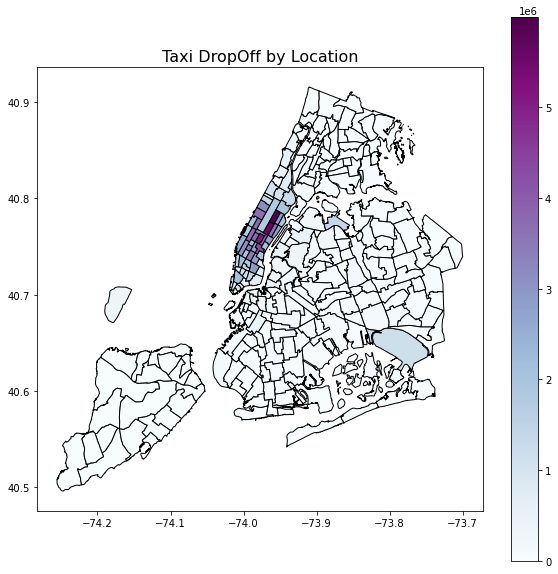

In [63]:
fig, ax = plt.subplots(figsize=(10, 10))
cmap = tzdata.plot(column='do_count', cmap='BuPu', legend=True, ax=ax, edgecolor='black')
cmap.set_title("Taxi DropOff by Location", fontsize = 16)
plt.show()

In [64]:
DO_unique = cabs_df.select('DOLocationID').distinct().orderBy(desc('DOLocationID'))
print(DO_unique.count())


9929


In [66]:
DO_unique.show(5)

+------------+
|DOLocationID|
+------------+
|   334303.19|
|   333574.57|
|   332302.69|
|   314199.07|
|   306821.42|
+------------+
only showing top 5 rows



In [67]:
pu_count_df_green = cabs_df.where(cabs_df.taxi_type == 'green').groupBy('PULocationID').agg(count('*').alias('count')).orderBy('PULocationID')

pu_count_df_green.show(5)

+------------+-------+
|PULocationID|  count|
+------------+-------+
|        null|1613788|
|         0.0|  16318|
|         1.0|6457909|
|         2.0| 549946|
|         3.0| 101232|
+------------+-------+
only showing top 5 rows



In [68]:
pu_count_pd_green = pu_count_df_green.toPandas()
tzdata = tzdata.merge(pu_count_pd_green, left_on='location_i', right_on='PULocationID',how='left')
tzdata = tzdata.rename(columns={'count': 'pu_count_green'}).drop('PULocationID', axis=1)
tzdata['pu_count_green'] = tzdata['pu_count_green'].fillna(0)
tzdata.head()

,borough,location_i,objectid,shape_area,shape_leng,zone,geometry,pu_count,do_count,pu_count_green
0,EWR,1.0,1.0,0.000782,0.116357,Newark Airport,"POLYGON ((-74.18445 40.69500, -74.18449 40.695...",6471692.0,335062.0,6457909.0
1,Queens,2.0,2.0,0.004866,0.433470,Jamaica Bay,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ...",550090.0,38899.0,549946.0
2,Bronx,3.0,3.0,0.000314,0.084341,Allerton/Pelham Gardens,"POLYGON ((-73.84793 40.87134, -73.84725 40.870...",107228.0,38353.0,101232.0
3,Manhattan,4.0,4.0,0.000112,0.043567,Alphabet City,"POLYGON ((-73.97177 40.72582, -73.97179 40.725...",254726.0,621084.0,37263.0
4,Staten Island,5.0,5.0,0.000498,0.092146,Arden Heights,"POLYGON ((-74.17422 40.56257, -74.17349 40.562...",208352.0,10979.0,207735.0


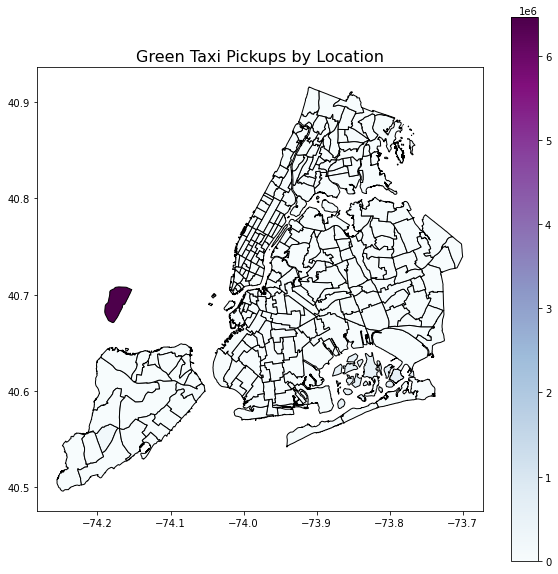

In [70]:
fig, ax = plt.subplots(figsize=(10, 10))
cmap = tzdata.plot(column='pu_count_green', cmap='BuPu', legend=True, ax=ax, edgecolor='black')
cmap.set_title("Green Taxi Pickups by Location", fontsize = 16)
plt.show()

In [71]:
pu_count_df_yellow = cabs_df.where(cabs_df.taxi_type == 'yellow').groupBy('PULocationID').agg(count('*').alias('count')).orderBy('PULocationID')

pu_count_df_yellow.show(5)

+------------+------+
|PULocationID| count|
+------------+------+
|         1.0| 13783|
|         2.0|   144|
|         3.0|  5996|
|         4.0|217463|
|         5.0|   617|
+------------+------+
only showing top 5 rows



In [72]:
pu_count_pd_yellow = pu_count_df_yellow.toPandas()
tzdata = tzdata.merge(pu_count_pd_yellow, left_on='location_i', right_on='PULocationID',how='left')
tzdata = tzdata.rename(columns={'count': 'pu_count_yellow'}).drop('PULocationID', axis=1)
tzdata['pu_count_yellow'] = tzdata['pu_count_yellow'].fillna(0)
tzdata.head()

,borough,location_i,objectid,shape_area,shape_leng,zone,geometry,pu_count,do_count,pu_count_green,pu_count_yellow
0,EWR,1.0,1.0,0.000782,0.116357,Newark Airport,"POLYGON ((-74.18445 40.69500, -74.18449 40.695...",6471692.0,335062.0,6457909.0,13783.0
1,Queens,2.0,2.0,0.004866,0.433470,Jamaica Bay,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ...",550090.0,38899.0,549946.0,144.0
2,Bronx,3.0,3.0,0.000314,0.084341,Allerton/Pelham Gardens,"POLYGON ((-73.84793 40.87134, -73.84725 40.870...",107228.0,38353.0,101232.0,5996.0
3,Manhattan,4.0,4.0,0.000112,0.043567,Alphabet City,"POLYGON ((-73.97177 40.72582, -73.97179 40.725...",254726.0,621084.0,37263.0,217463.0
4,Staten Island,5.0,5.0,0.000498,0.092146,Arden Heights,"POLYGON ((-74.17422 40.56257, -74.17349 40.562...",208352.0,10979.0,207735.0,617.0


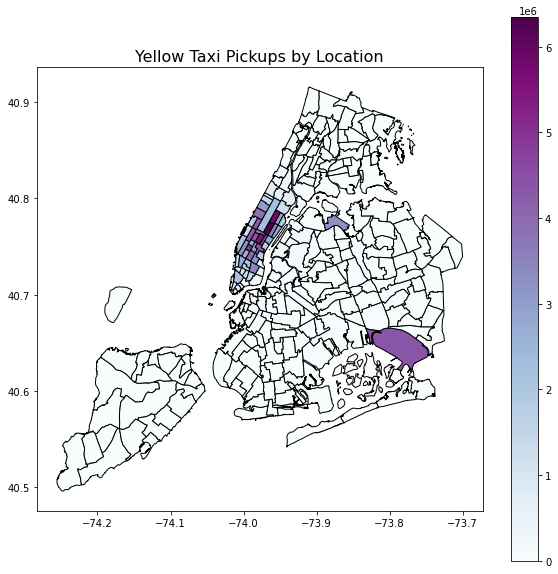

In [74]:
fig, ax = plt.subplots(figsize=(10, 10))
cmap = tzdata.plot(column='pu_count_yellow', cmap='BuPu', legend=True, ax=ax, edgecolor='black')
cmap.set_title("Yellow Taxi Pickups by Location", fontsize = 16)
plt.show()